# Water Vapour

In [1]:
from datetime import datetime
from siphon.catalog import TDSCatalog
from datetime import datetime
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots import colortables
from metpy.plots import add_timestamp
import numpy             as np
import os                as os
import pandas             as pd


In [2]:
# %load solutions/data_url.py
total_frames = 45*2
os.system("rm -v ./sat_wv_temp_files/*")


# Cell content replaced by load magic replacement.

# Create variables for URL generation
image_date = datetime.utcnow().date()
region = 'CONUS'
channel = 8

# We want to match something like:
# https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

# Construct the data_url string
data_url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/current/catalog.xml')

# Print out your URL and verify it works!
print(data_url)


./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0011.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0016.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0021.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0026.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0031.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0036.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0041.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0046.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0051.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0056.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0101.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0106.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0111.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0116.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0121.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0126.png
./sat_wv_temp_files/Sat_WV_Loop_Image_2022-01-30_0131.png
./sat_wv_temp_

In [3]:
cat = TDSCatalog(data_url)

In [4]:
cat.datasets[1:total_frames]

[OR_ABI-L2-CMIPC-M6C08_G16_s20220300356170_e20220300356170_c20220300356170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300351170_e20220300351170_c20220300351170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300346170_e20220300346170_c20220300346170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300341170_e20220300341170_c20220300341170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300336170_e20220300336170_c20220300336170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300331170_e20220300331170_c20220300331170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300326170_e20220300326170_c20220300326170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300321170_e20220300321170_c20220300321170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300316170_e20220300316170_c20220300316170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300311170_e20220300311170_c20220300311170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300306170_e20220300306170_c20220300306170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300301170_e20220300301170_c20220300301170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20220300256170_e20220300

In [5]:
len(cat.datasets[1:total_frames])

89

2022-01-30 03:56:17 UTC 2022-01-29 20:56:17 MST
2022-01-30 03:46:17 UTC 2022-01-29 20:46:17 MST
2022-01-30 03:36:17 UTC 2022-01-29 20:36:17 MST
2022-01-30 03:26:17 UTC 2022-01-29 20:26:17 MST
2022-01-30 03:16:17 UTC 2022-01-29 20:16:17 MST
2022-01-30 03:06:17 UTC 2022-01-29 20:06:17 MST
2022-01-30 02:56:17 UTC 2022-01-29 19:56:17 MST
2022-01-30 02:46:17 UTC 2022-01-29 19:46:17 MST
2022-01-30 02:36:17 UTC 2022-01-29 19:36:17 MST
2022-01-30 02:26:17 UTC 2022-01-29 19:26:17 MST
2022-01-30 02:16:17 UTC 2022-01-29 19:16:17 MST
2022-01-30 02:06:17 UTC 2022-01-29 19:06:17 MST
2022-01-30 01:56:17 UTC 2022-01-29 18:56:17 MST
2022-01-30 01:46:17 UTC 2022-01-29 18:46:17 MST
2022-01-30 01:36:17 UTC 2022-01-29 18:36:17 MST
2022-01-30 01:26:17 UTC 2022-01-29 18:26:17 MST
2022-01-30 01:16:17 UTC 2022-01-29 18:16:17 MST
2022-01-30 01:06:17 UTC 2022-01-29 18:06:17 MST
2022-01-30 00:56:17 UTC 2022-01-29 17:56:17 MST
2022-01-30 00:46:17 UTC 2022-01-29 17:46:17 MST
2022-01-30 00:36:17 UTC 2022-01-29 17:36

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

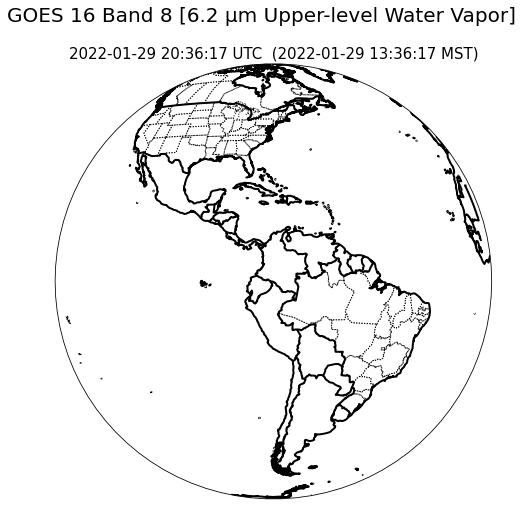

In [6]:
for i in range(1,len(cat.datasets[1:total_frames])+1,2) : 

    dataset = cat.datasets[i]
    ds = dataset.remote_access(use_xarray=True)
    dat = ds.metpy.parse_cf('Sectorized_CMI')
    proj = dat.metpy.cartopy_crs
    x = dat['x']
    y = dat['y']


    tz='America/Denver'
    time_utc = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
    valid_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d %H:%M:%S %Z")
    local_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").tz_convert(tz=tz).strftime("%Y-%m-%d %H:%M:%S %Z")

    file_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d_%H%M")


    print(valid_time,local_time)



    fig = plt.figure(figsize=(13, 8),
                           facecolor = 'white')

    plt.suptitle("GOES 16 Band 8 [6.2 µm Upper-level Water Vapor]",
                    fontsize=20)
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_title(valid_time + "  (" + local_time+")",
                    fontsize=15)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':', edgecolor='black')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=2, edgecolor='black')

    im = ax.imshow(dat, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')

    wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 195, 265)
    im.set_cmap(wv_cmap)
    im.set_norm(wv_norm)
    plt.tight_layout()
    plt.savefig("./sat_wv_temp_files/Sat_WV_Loop_Image_"+file_time+".png")
    plt.close()
    



In [ ]:
##################################################
#
# Convert PNGs into an Animated GIF
#

os.system("convert -delay 15 " + 
          "./sat_wv_temp_files/Sat_WV_Loop_Image_*.png"  + 
          " " + 
          "./graphics_files/RealTime_SAT_WV_Loop.gif")


#
##################################################